# Python API introduction

IFermi is a fully featured Python 3.6+ library for the generation, 
analysis, and visualisation of Fermi surfaces and Fermi slices. The goal of the library 
is to provide full featured `FermiSurface` and `FermiSlice` objects that allow for easy 
manipulation and analysis. The main features include:

- Interpolation of electronic band structures onto dense k-point meshes.
- Extraction of Fermi surfaces and Fermi slices from electronic band structures.
- Projection of arbitrary properties on to Fermi surfaces and Fermi slices.
- Tools to calculate Fermi surface dimensionality, orientation, and averaged projections.
- Interactive visualisation of Fermi surfaces and slices, with support for
  [mayavi](https://docs.enthought.com/mayavi/mayavi/), [plotly](https://plot.ly/) and 
  [matplotlib](https://matplotlib.org).
- Generation and visualisation of spin-texture.

Many of the options provided in the Python API are also accessible from the [command-line](https://fermisurfaces.github.io/IFermi/cli.html). This notebook gives a demonstration of how to use the Python library.

<div class="alert alert-warning">
**Warning**
<p>IFermi currently only works with VASP calculations but support for additional DFT packages will be added in the future.</p>
</div>


The overall workflow for using IFermi can be summarised as:

1. Load DFT calculation outputs to create a `BandStructure` object.
2. Interpolate the band structure onto a dense k-point mesh using the `FourierInterpolater` class that is based on [BoltzTraP2](https://gitlab.com/sousaw/BoltzTraP2).
3. Extract the Fermi surface at a given energy level to create a `FermiSurface` object.
4. (Optionally) slice the Fermi surface along a plane to create a `FermiSlice` object.
5. The library provides a rich set of functions for the analysis and visualisation of `FermiSurface` and `FermiSlice` objects. 

Below, we provide details for each of these steps. This page can also be run as an [interactive jupyter notebook](https://github.com/fermisurfaces/IFermi/blob/master/examples/introdu.ipynb).

## Loading VASP outputs

The first step is to load the VASP calculation outputs needed for the plot. This is achieved using the [pymatgen](https://pymatgen.org) package, which contains classes for parsing outputs and representing band structure calculations.

The only input required is a vasprun.xml file. Here, we use the MgB$_2$ calculation data in the `examples/MgB2/` folder. We first load the vasprun.xml using the `Vasprun` class.

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from pymatgen.io.vasp.outputs import Vasprun

vr = Vasprun('MgB2/vasprun.xml')

Next, we extract the band structure information into a `BandStructure` object. This class contains information on the eigenvalues, k-points, and reciprocal lattice vectors.

In [3]:
bs = vr.get_band_structure()

## Interpolating onto a dense k-point mesh

There are currently two issues with our extracted band structure:

1. It only contains the irreducible portion of the Brillouin zone (since symmetry was used in the calculation) and therefore does not contain enough information to plot the Fermi surface across the full reciprocal lattice.
2. It was calculated on a relatively coarse k-point mesh and therefore will produce a rather jagged Fermi surface.

Both issues can be solved be interpolating the band structure onto a denser k-point mesh. This can be achieved using the `FourierInterpolator` class. Internerally, this class uses the [BoltzTraP2 package](https://gitlab.com/sousaw/BoltzTraP2) to Fourier interpolate the eigenvalues on to a denser mesh that covers the full Brillouin zone.

The interpolater can be initialized using a `BandStructure` object as input.

In [4]:
from ifermi.interpolate import FourierInterpolator

interpolator = FourierInterpolator(bs)

The band structure can be interpolated using the `interpolate_bands()` function. The degree of interpolation is controlled by the `interpolation_factor` argument. A value of `5`, roughly indicates that the interpolated band structure will contain 5x as many k-points. Increasing the interpolation factor will result in smoother Fermi surfaces.

<div class="alert alert-warning">
**Warning**
<p>As the interpolation increases, the generation of the Fermi surface and plot will take a longer time and can result in large file sizes.</p>
</div>

In [5]:
dense_bs = interpolator.interpolate_bands(interpolation_factor=5)

The `interpolate_bands()` function returns both the band structure on a dense k-point mesh.

To include the group velocity as a Fermi surface property, the velocities can be calculated during interpolation by setting the `return_velocities` option.

In [6]:
dense_bs, velocities = interpolator.interpolate_bands(interpolation_factor=5, return_velocities=True)

## Generating Fermi surfaces

The next step is to extract the Fermi surface from the band structure. The `FermiSurface.from_band_structure()` function generates a `FermiSurface` object from the dense band structure we just created.

This function has a number of options that are detailed in the [FermiSurface API Reference page](https://fermisurfaces.github.io/IFermi/ifermi.html#ifermi.surface.FermiSurface). The two key options are:

1. `mu` (default: `0.0`) which controls the energy offset at which the Fermi surface is calculated.
2. `wigner_seitz` (default: `False`) which controls whether the Fermi surface is calculated in the Wigner–Seitz cell or the parallelepiped reciprocal lattice cell.

MgB<sub>2</sub> is metallic, so we are mainly interested in the Fermi surface at the Fermi level. 

<div class="alert alert-info">
**Note**
<p>For gapped materials, <code>mu</code> must be adjusted so that it falls within the conduction band or valence band otherwise no Fermi surface will be displayed.</p>
</div>

In [7]:
from ifermi.surface import FermiSurface

fs = FermiSurface.from_band_structure(dense_bs, mu=0.0, wigner_seitz=True)

To include a property in the Fermi surface, we can supply the `property_data` and `property_kpoints` options during Fermi surface generation. The only requirement is that the propery k-points cover the entire Brillouin zone. For example:

In [8]:
from ifermi.kpoints import kpoints_from_bandstructure

dense_kpoints = kpoints_from_bandstructure(dense_bs)

fs = FermiSurface.from_band_structure(
    dense_bs, 
    property_data=velocities,
    property_kpoints=dense_kpoints,
)

To calculate Fermi surface properties such as the dimensionality and orientation, the `calculate_dimensionality` option can be used.

In [9]:
fs = FermiSurface.from_band_structure(
    dense_bs,
    wigner_seitz=True,
    property_data=velocities,
    property_kpoints=dense_kpoints,
    calculate_dimensionality=True
)

## Analyzing Fermi surfaces 

The `FermiSurface` object includes a rich API that can be used to calcualate many properties of the Fermi surface. The principle attribute is `isosurfaces`. This contains an an `Isosurface` object for each fully-connected surface. The isosurfaces are given for each spin channel in the band structure. The [FermiSurface API Reference page](https://fermisurfaces.github.io/IFermi/ifermi.html#ifermi.surface.FermiSurface) gives a list of all available attributes. 

The number of isosurfaces can be obtained using:

In [10]:
fs.n_surfaces

10

The number of isosurfaces in each spin channel is available using:

In [11]:
fs.n_surfaces_per_spin

{<Spin.up: 1>: 5, <Spin.down: -1>: 5}

The total area of the Fermi surface:

In [12]:
fs.area

32.63033435193189

And the area of each isosurface in each spin channel.

In [13]:
fs.area_surfaces

{<Spin.up: 1>: array([1.9257198 , 4.35767606, 2.94401577, 3.54389684, 3.54389612]),
 <Spin.down: -1>: array([1.92566855, 4.35765367, 2.94401459, 3.54389684, 3.54389612])}

The isosurfaces for each spin channel can be accessed using the pymatgen `Spin` object.

In [14]:
from pymatgen import Spin

fs.isosurfaces[Spin.up]

[Isosurface(nvertices=524, nfaces=808, band_idx=5, dim=2D, orientation=(0, 0, 1)),
 Isosurface(nvertices=1560, nfaces=1914, band_idx=6, dim=1D, orientation=(0, 0, 1)),
 Isosurface(nvertices=736, nfaces=1136, band_idx=6, dim=2D, orientation=(0, 0, 1)),
 Isosurface(nvertices=1392, nfaces=1680, band_idx=7, dim=1D, orientation=(0, 0, 1)),
 Isosurface(nvertices=1396, nfaces=1682, band_idx=7, dim=1D, orientation=(0, 0, 1))]

The `Isosurface` object has several utility methods for accessing and manipulating the isosurface properties. The [Isosurface API Reference page](https://fermisurfaces.github.io/IFermi/ifermi.html#ifermi.surface.Isosurface) gives the full documentation.

First, we select the first isosurface in the Spin up channel.

In [15]:
isosurface = fs.isosurfaces[Spin.up][0]

The area of the isosurface is obtained through:

In [16]:
isosurface.area

1.9257197973874718

If the Fermi surface was generated using `calculate_dimensionality=True`, the dimensionality of the isosurface (i.e., whether the surface cross periodic boundaries) can be obtained using.

In [17]:
isosurface.dimensionality

'2D'

For 2D and 1D isosurfaces, their orientation is available through:

In [18]:
isosurface.orientation

(0, 0, 1)

There are a number of functions for manipulating the face properties of isosurfaces.

In [19]:
# does the surface have face properties
isosurface.has_properties

# calculate the norms of the properties
isosurface.properties_norms

# calculate scalar projection of properties on to [0 0 1] vector
isosurface.scalar_projection((0, 0, 1))

# get the average property across the surface
isosurface.average_properties()

# get the average of the property norms across the surface
isosurface.average_properties(norm=True)

0.32396548486124893

Furthermore, it is possible to sample the isosurface faces to a consistent density using:

In [20]:
# returns the indices of the faces that give uniform density
isosurface.sample_uniform(0.1)

array([795, 735, 253, 239, 242, 259, 261, 263, 793, 731, 212, 214, 217,
       202, 204, 206, 773, 718, 345, 347, 370, 369, 367, 365, 362, 354,
       353, 349, 383, 402, 399, 397, 395, 780, 238, 241, 243, 522, 525,
       527, 528, 533, 535, 538, 539, 541, 256, 258, 260, 693, 225, 116,
       215, 544, 546, 551, 553, 555, 557, 559, 563, 512, 479, 481, 200,
       113, 110, 751, 723, 496, 499, 501, 504, 506, 509, 561, 495, 494,
       484, 487, 488, 490, 783, 721, 470, 471, 432, 474, 475, 477, 802,
       445, 434, 436, 442, 444, 426, 424, 407, 409, 412, 414, 416, 419,
       420, 635, 636, 727, 654, 656, 658, 677, 687, 682, 650, 679, 637,
       639, 642, 644, 646, 649, 675, 661, 652, 787, 730,  91,  93, 124,
       127, 772, 712, 223, 265,  95, 320, 100, 104, 176, 174, 172, 170,
       168, 107, 109, 119, 335, 336, 338, 797,   8,  10,  12,  14,  16,
       300, 301, 303, 305, 285, 283, 728, 308, 310,  33, 314, 316, 341,
        26,  42,  20,  50,  88,  85,  83,  81,  78,  76,  75, 76

## Fermi slices

IFermi can also generate two-dimensional slices of the Fermi surface along a specified plane. Planes are defined by their miller indices (j k l) and a distance from the plane, d. `FermiSlice` objects can be generated directly from `FermiSurface` objects.

In [21]:
import numpy as np

fermi_slice = fs.get_fermi_slice(plane_normal=(0, 0, 1), distance=0)

The `FermiSlice` object includes a rich API that can be used to calcualate many properties of the Fermi slice. The principle attribute is `isolines`. This contains an an `Isoline` object for each fully-connected line in the slice. The isolines are given for each spin channel in the band structure. The [FermiSlice API Reference page](https://fermisurfaces.github.io/IFermi/ifermi.html#ifermi.slice.FermiSlice) gives a list of all available attributes. Below we showcase a few of the functions available.

In [22]:
# number of isolines in the slice
fermi_slice.n_lines

# do the lines have segment properties
fermi_slice.has_properties

# get the first isoline in the Spin up channel
isoline = fermi_slice.isolines[Spin.up][0]

# calculate the norms of the properties
isoline.properties_norms

# calculate scalar projection of properties on to [0 0 1] vector
isoline.scalar_projection((0, 0, 1))

# sample the line at a consistent density
# returns the indices of the segments that give the desired spacing
isoline.sample_uniform(0.1)

array([ 50, 159, 266, 373, 479, 588, 693])

## Visualising Fermi surfaces and slices

IFermi includes a rich set of visualisation tools for plotting `FermiSurface` and `FermiSlice` objects.

Fermi surfaces can be visualised using the `FermiSurfacePlotter` class. This object supports plotting using [matplotlib](https://matplotlib.org), [plotly](https://plot.ly/) and [mayavi](https://docs.enthought.com/mayavi/mayavi/) (provided the `mayavi` package [is installed](https://docs.enthought.com/mayavi/mayavi/installation.html)). The detailed documentation is available on the [FermiSurfacePlotter API Reference page](https://fermisurfaces.github.io/IFermi/ifermi.html#ifermi.plot.FermiSurfacePlotter).

First, the plotter is initialised from a `FermiSurface` object.

In [23]:
from ifermi.plot import FermiSurfacePlotter

fs = FermiSurface.from_band_structure(dense_bs, mu=0.0, wigner_seitz=True)

plotter = FermiSurfacePlotter(fs)

Next, we can use the `get_plot()` function, to get a plot object. The plotting backend is controlled using the `plot_type` option. The available options are:

- `plotly` (default): We use this for all plots in this notebook.
- `matplotlib`
- `mayavi`: Requires `vtk` and `mayavi` to be installed.

The plot can be displayed directly in a jupyter notebook by calling the `show()` function.

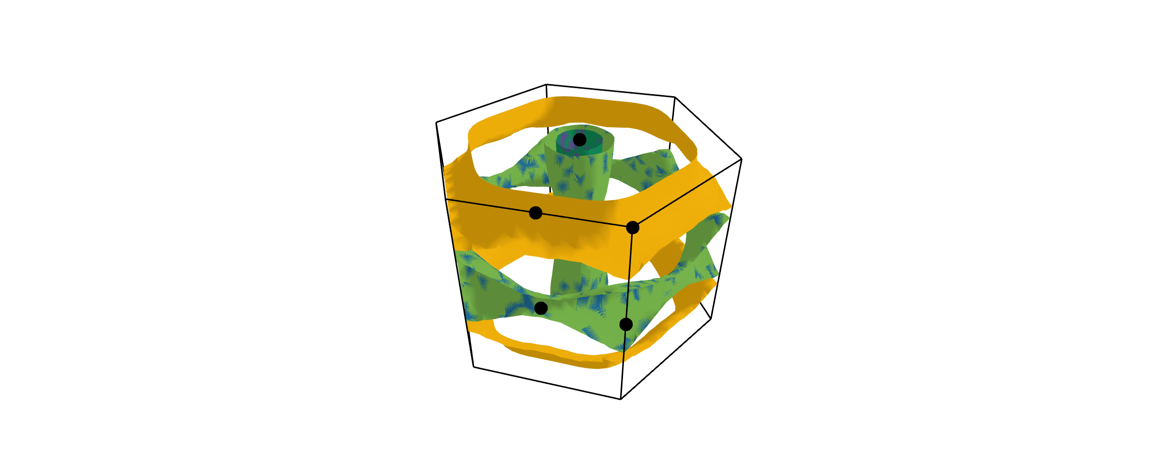

In [24]:
plot = plotter.get_plot(plot_type="plotly")
plot.show()

### Selecting spin channels

In the plot above, the spins are degenerate (the Hamiltonian does not differentiate between the up and down spins). This is why the surface looks dappled - the plotter is plotting two redundant sufaces. To stop it from doing this, we can specify that only one component of the spin should be plotted.

*Note: from now on we omit the `plot_type` argument.*

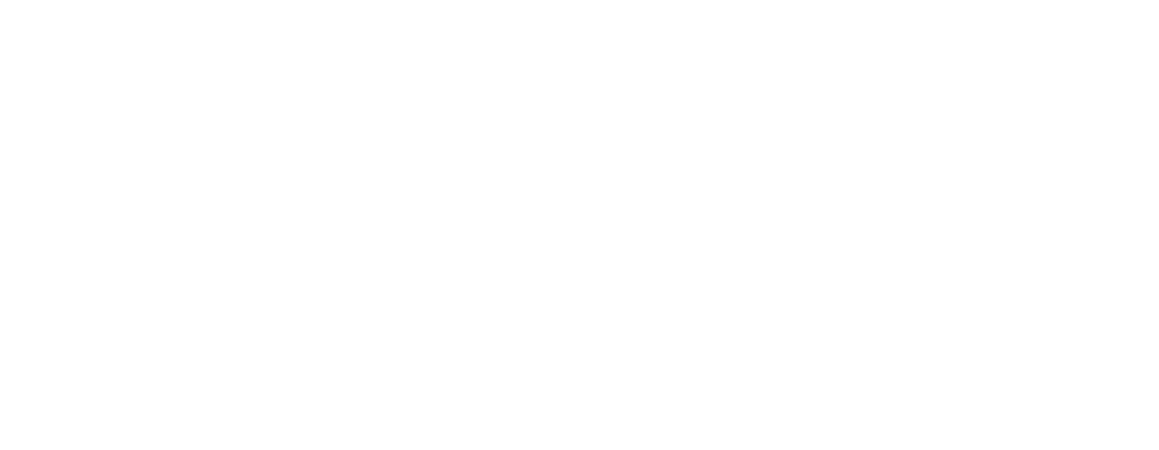

In [25]:
from pymatgen import Spin

plot = plotter.get_plot(spin=Spin.up)
plot.show()

### Styling face properties

As described in the [Generating Fermi surfaces](#Generating Fermi surfaces) section, Fermi surfaces (and Fermi slices) can include a property projected onto the isosurface faces. By default, if properties are included in the Fermi surface they will be indicated by coloring of the isosurface. If the face property is a vector, the norm of the vector will be used as the color intensity. The colormap of the surface can be changed using the `properties_colormap` option. All [matplotlib colormaps](https://matplotlib.org/stable/gallery/color/colormap_reference.html) are supported. For example:

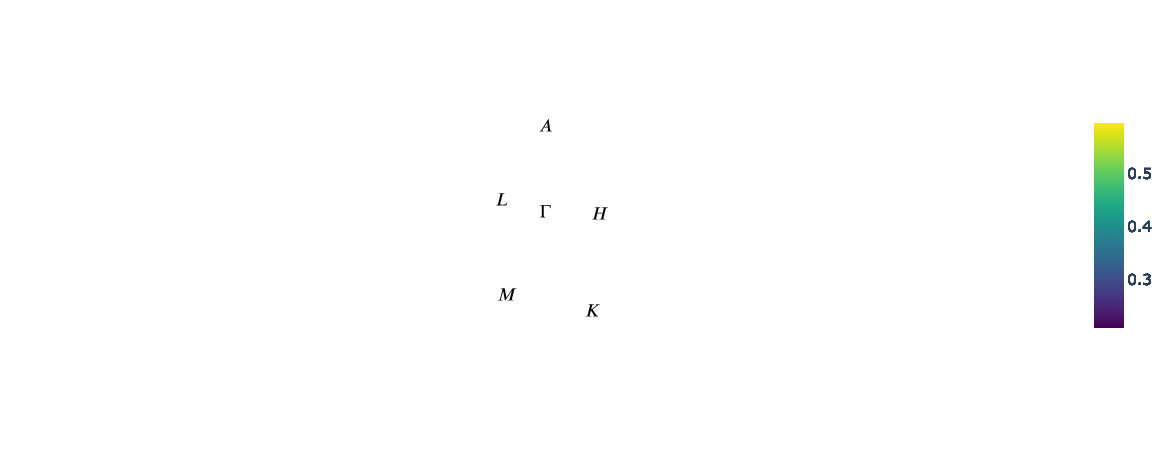

In [26]:
fs = FermiSurface.from_band_structure(
    dense_bs, 
    wigner_seitz=True,
    property_data=velocities,
    property_kpoints=dense_kpoints,
)

plotter = FermiSurfacePlotter(fs)

plot = plotter.get_plot()
plot.show()

The minimum and maximum values for the colorbar limits can be set using the `cmin` and `cmax` parameters. These should be used when quantitatively comparing surface properties between two plots.

It is also possible calculate the scalar projection of the face properties onto a cartesian axis using the `projection_axis` option. When
combined with a diverging colormap this can be used to indicate surface properties that vary between positive and negative numbers. For example, by setting `projection_axis=(0, 0, 1)`, the surface will be colored by the projection of the group velocity onto the \[0 0 1\] vector (z-axis). 

### Plotting Arrows

Vector valued Fermi surface properties (such as group velocity or spin magnetisation) can also be visualised as arrows by setting  `vector_properties=True`. If `projection_axis` is set, the color of the arrows will be determined by the scalar projection of the property vectors onto the specified axis, otherwise the norm of the projections will be used. The colormap used to color the arrows is specified by setting `vector_properties` to the colormap name. Often it is useful to hide the isosurface (`hide_surface=True`) or high-symmetry labels (`hide_labels=True`) when visualising arrows. 

The size of the arrows can be controlled using the `vnorm` parameter. This is particularly useful when quantitatively comparing vector properties across multiple Fermi surfaces. A larger `vnorm` value will increase the size of the arrows. The spacing between the arrows is controlled by the `vector_spacing` option. Smaller values will increase the density of the arrows.

An example of how to combine these options is given below:

In [27]:
plot = plotter.get_plot(
    vector_properties="RdBu",
    projection_axis=(0, 0, 1),
    hide_surface=True,
    hide_labels=True
)
# plot.show()

### Fermi slices

Fermi slices can be visualised using the `FermiSlicePlotter` class. This object only supports plotting using [matplotlib](https://matplotlib.org). The detailed documentation is available on the [FermiSlicePlotter API Reference page](https://fermisurfaces.github.io/IFermi/ifermi.html#ifermi.plot.FermiSlicePlotter)

First, the plotter is initialised from a `FermiSlice` object.

In [28]:
from ifermi.plot import FermiSlicePlotter

slice_plotter = FermiSlicePlotter(fermi_slice)

The plot is generated using the `get_plot()` function.

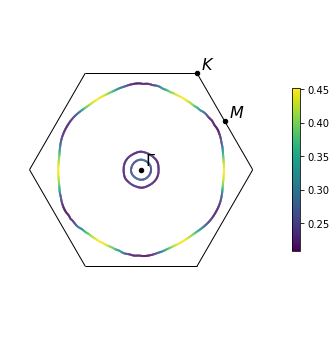

In [29]:
plot = slice_plotter.get_plot()
plot.show()

Many of the same options for visualing Fermi surfaces, including projections and arrows, are also available for Fermi slices. When including arrows in Fermi slice figures, only the components of the arrows in the 2D plane will be shown. 

### Exporting figures

The `plot.show()` works well for viewing Fermi surfaces in a notebook but doesn't work when generating plots as part of a standalone script.

To help displaying interactive plots and saving static images you should use the `show_plot` and `save_plot` functions.

<div class="alert alert-info">
**Note**
<p>Once a plot has been shown, it cannot then be saved. Instead you should save the plot first then show it.</p>
</div>

In [30]:
from ifermi.plot import show_plot, save_plot

save_plot(plot, "fermi-surface.png")  # saves the plot to a file
show_plot(plot)  # displays an interactive plot

<Figure size 432x288 with 0 Axes>